In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random
import xgboost as xgb
import pandas as pd
import os
import pickle

random.seed(42)
np.random.seed(42)


In [3]:
from folktables import ACSDataSource, ACSIncome

data_source = []
features_years, label_years, group_years = [], [], []
for year in ['2017', '2018']:
    data_source = ACSDataSource(survey_year=year, horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=["CA"], download=True)
    features_i, label_i, group_i = ACSIncome.df_to_numpy(acs_data)
    features_years.append(features_i)
    label_years.append(label_i)
    group_years.append(group_i)

features = np.concatenate(features_years)
label = np.concatenate(label_years)
group = np.concatenate(group_years)

In [4]:
ACSIncome.features

['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P']

In [5]:
ACSIncome.target

'PINCP'

In [14]:
p = 1
train_size = int(p*features_years[0].shape[0])
features_train, labels_train = features[:train_size], label[:train_size]
features_test, labels_test = features[train_size:], label[train_size:]

features_train.shape, features_test.shape

((192929, 10), (195665, 10))

In [18]:
df_train_unproc = pd.DataFrame(features_train, columns=ACSIncome.features)
df_test_unproc = pd.DataFrame(features_test, columns=ACSIncome.features)

In [19]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num = ['AGEP',  'WKHP']
categ = [ 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX', 'RAC1P']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categ)])

In [20]:
df_train_prep = preprocessor.fit_transform(df_train_unproc)

In [22]:

xgb_model = xgb.XGBClassifier()
xgb_model.fit(df_train_prep, labels_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [23]:
df_test_prep = preprocessor.transform(df_test_unproc)

In [24]:
ckpt_dir = 'folktables'
os.makedirs(ckpt_dir, exist_ok=True)

model_filename = os.path.join(ckpt_dir, f"xgb_folktables.pkl")
with open(model_filename, "wb") as f:
        pickle.dump(xgb_model, f)


ds_filename = os.path.join(ckpt_dir, f"folktables_data.pkl")

with open(ds_filename, "wb") as f:
        pickle.dump({
                "train": df_train_unproc,
                "test_chunks": df_test_unproc,
                "numerical": num,
                "categorical": categ,
                "transform": preprocessor
        }, f)

In [25]:
xgb_model.score(df_test_prep, labels_test)

0.8129813712212199

In [26]:
labels_test_pred= xgb_model.predict(df_test_prep)

In [28]:
accs = []
from sklearn.metrics import accuracy_score

size_year_1 = (features_years[0].shape[0]-train_size)/5000

batch_size = 5000
s = 0
for batch_i, b in enumerate(range(batch_size, df_test_prep.shape[0], batch_size)):
    
    labels_test_i = labels_test[:b]
    labels_test_pred_i = xgb_model.predict(df_test_prep[:b])
    accs.append( accuracy_score(labels_test_i, labels_test_pred_i))
    if batch_i < size_year_1:
        s = batch_i


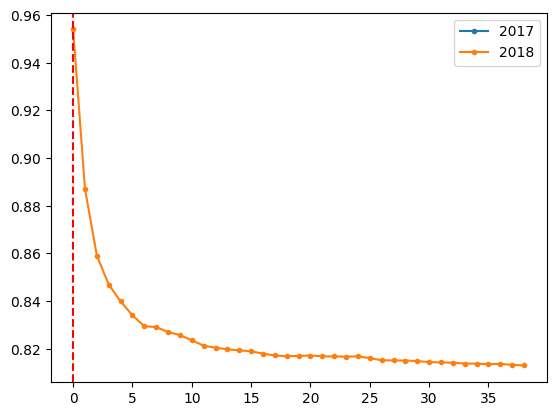

In [29]:
import matplotlib.pyplot as plt
plt.plot(accs[:s], '.-', label='2017')
plt.plot(range(s, len(accs)), accs[s:], '.-', label='2018')
plt.axvline((features_years[0].shape[0]-train_size)/5000, color='r', linestyle='--')
plt.legend()

# Use drift explorer

In [30]:
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

bool_preprocessor = ColumnTransformer(
transformers=[
    # numerical features : bins + 1-hot
    ('num', Pipeline([
        ('bins', KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='uniform')),
        ]), num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categ)], 
    sparse_threshold=0)

In [31]:

import sys
sys.path.append("..")
from divexp import *
from tqdm import tqdm

minsup = 0.01


df_train_unsup = pd.DataFrame(data=bool_preprocessor.fit_transform(df_train_unproc), columns=bool_preprocessor.get_feature_names_out()).astype(bool)

In [32]:

matches = compute_matches(df_train_unsup, minsup=minsup, n_proc=36)

matches_ts_list = []
df_tests = []
from tqdm import tqdm 

batch_size = 20000 
num_iterations = df_test_unproc.shape[0] // batch_size

df_tests_unsup = []
for i in range(num_iterations + 1):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    df_test_i = df_test_unproc[start_idx:end_idx]
    df_test_unsup = pd.DataFrame(bool_preprocessor.transform(df_test_i), columns=bool_preprocessor.get_feature_names_out()).astype(bool)
    matches_ts = compute_matches(df_test_unsup, fi=matches.fi)
    matches_ts_list.append(matches_ts)
    df_tests_unsup.append(df_test_unsup)

In [50]:
y_trues = []
y_preds = []

divs = []

for i in range(num_iterations + 1):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    df_test_prep_i = df_test_prep[start_idx:end_idx]
    y_true_i = labels_test[start_idx:end_idx]
    y_pred_i = xgb_model.predict(df_test_prep_i)

    matches_ts_i = matches_ts_list[i]

    y_trues.extend(y_true_i)
    y_preds.extend(y_pred_i)

    divs.append(div_explorer(matches_ts_i, y_trues, y_preds, ['accuracy']))

ValueError: dimension mismatch

In [51]:
matches_ts_i

Matches(matches=<20000x6071 sparse array of type '<class 'numpy.bool_'>'
	with 3255130 stored elements in Compressed Sparse Row format>, fi=       support        itemsets
0     0.531486           (764)
1     0.527355            (42)
2     0.467270           (746)
3     0.307009             (1)
4     0.169264            (33)
...        ...             ...
6066  0.010683       (10, 763)
6067  0.010750  (46, 763, 766)
6068  0.010294  (528, 763, 46)
6069  0.016130    (0, 763, 46)
6070  0.010035  (763, 764, 46)

[6071 rows x 2 columns])

In [52]:
len(y_trues), len(y_preds)

(20000, 20000)

In [43]:
matches_ts_i

Matches(matches=<20000x6071 sparse array of type '<class 'numpy.bool_'>'
	with 3255130 stored elements in Compressed Sparse Row format>, fi=       support        itemsets
0     0.531486           (764)
1     0.527355            (42)
2     0.467270           (746)
3     0.307009             (1)
4     0.169264            (33)
...        ...             ...
6066  0.010683       (10, 763)
6067  0.010750  (46, 763, 766)
6068  0.010294  (528, 763, 46)
6069  0.016130    (0, 763, 46)
6070  0.010035  (763, 764, 46)

[6071 rows x 2 columns])

In [38]:
len(matches_ts)

2

In [35]:
for (x, y), (mask_batch,) in tqdm(zip(dl, dl_mask), total=len(dl)):
                    md = y[:, metadata_mask].numpy().astype(int)

                    # apply blur, if required
                    # if blur is not None:
                    #     # only add noise to points in target subgroups
                    #     # mask = (md[:, sg] == 1).all(axis=1)
                    #     if mask.any():
                    #         num_altered += mask.sum()
                    #         x[mask] = blur(x[mask])
                    if blur is not None and mask_batch.any():
                        num_altered += mask_batch.sum().item()
                        x[mask_batch] = blur(x[mask_batch])
                    
                    if mask_batch.any() and samples[pos] is None:
                        samples[pos] = x[mask_batch][0].cpu().numpy().transpose(1, 2, 0)

                    out = model(x.to(args.device))
                    preds = (out > 0).cpu().numpy().astype(int)
                    y_pred.extend(preds)
                    y_true.extend(y[:, attr_id].numpy().astype(int))
                    metadata.extend(md)
                
                y_true = np.hstack(y_true)
                y_pred = np.hstack(y_pred)
                metadata = np.vstack(metadata)

                y_trues.append(y_true)
                y_preds.append(y_pred)

                divs.append(div_explorer(matches_ts, y_true, y_pred, [args.metric]))

True